# Kidney Disease Prediction & Risk Stratification Through Machine Learning
### Capstone Project for NWMSU Master of Science in Data Analytics Program  
Data Source: [Behavioral Risk Factor Surveillance System 2021](https://www.cdc.gov/brfss/annual_data/annual_2021.html), [Behavioral Risk Factor Surveillance System 2019](https://www.cdc.gov/brfss/annual_data/annual_2019.html)    
Author: Amanda Hanway  
Date: 7/8/23   


--- 
## Setup

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE 
import xgboost as xgb
from datetime import datetime
from sqlalchemy import create_engine
from io import StringIO
import psycopg2
import csv
import pickle

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None 

# functions
def psql_insert_copy(table, conn, keys, data_iter):
    ''' gets a dbapi connection tha can provide a cursor
    improving write speed with copy in conjunction with python, sqlalchemy, and pandas
    to get the same speed as with the \copy command in psql to write data to a database
    '''
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)
        
        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name
                
        sql = 'copy {} ({}) from stdin with csv'.format(table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)   

def plot_cm(title, data, labels):
    '''confusion matrix'''
    fig, ax = plt.subplots(figsize=(4,2))
    ax.axhline(y=0.5, color='black', linewidth=0.2)
    ax.axvline(x=0.5, color='black', linewidth=0.2)
    disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='g', colorbar=False, ax=ax)
    plt.title(title,fontsize=10)
    plt.show()        

---
## 1. Load the Full Data File for Processing
- The file includes survey responses to a variety of behavioral risk factor questions from the 2021 Behavioral Risk Factor Surveillance System (BRFSS).  
- Each row represents one respondent. Each column represents the respondent's answer to each question.
- I saved this dataframe to a new csv file in case I need to reference it later.  
- There are 438,693 rows and 303 columns.

In [2]:
source_file = 'C:\\Users\mandi\data_files\llcp2021.xpt'

# read the file into a dataframe
df = pd.read_sas(source_file, format='xport', encoding='iso-8859-1')

# add an id field
df.insert(loc=0, column='respondent_id',  value=np.arange(len(df)))
df['respondent_id'] = "2021-" + df['respondent_id'].astype(str)

# save to file
df.to_csv('1-brfss_2021_dataframe.csv', index = False)
print("Rows/columns: ", df.shape)
print(df.describe(include='all'))

Rows/columns:  (438693, 304)
       respondent_id         _STATE         FMONTH     IDATE  IMONTH    IDAY   
count         438693  438693.000000  438693.000000    438693  438693  438693  \
unique        438693            NaN            NaN       420      12      31   
top           2021-0            NaN            NaN  03092021      03      08   
freq               1            NaN            NaN      1906   44971   16505   
mean             NaN      30.742155       6.405680       NaN     NaN     NaN   
std              NaN      15.334888       3.421731       NaN     NaN     NaN   
min              NaN       1.000000       1.000000       NaN     NaN     NaN   
25%              NaN      20.000000       3.000000       NaN     NaN     NaN   
50%              NaN      31.000000       6.000000       NaN     NaN     NaN   
75%              NaN      41.000000       9.000000       NaN     NaN     NaN   
max              NaN      78.000000      12.000000       NaN     NaN     NaN   

         I

---
## 2. Create a Working Subset
- After loading the entire file, I created a subset to make the file easier to work with.  
- I included questions I thought would be most-relevant to Kidney Disease based on research plus some related to environmental and behavioral factors.   
- To identify the column names and questions, I referred to the Codebook for details: https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf
- I saved this subset to a new file.  

In [3]:
keep_col = [
    '_STATE', 'SEXVAR', '_AGE_G', 'BPHIGH6', 'TOLDHI3', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 
    'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA', 'CHILDREN', 'INCOME3', 'SMOKDAY2', '_METSTAT', '_URBSTAT', 
    '_IMPRACE', '_RFHLTH', '_HLTHPLN', '_RFHYPE6', '_BMI5CAT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFDRHV7', 
    '_FRTLT1A', '_VEGLT1A', 'EXERANY2'
]

# extract the needed columns into a new working df
work_df = df[keep_col]
print("Rows/columns: ", work_df.shape)

# write the data to an excel file
work_df.to_csv('2-brfss_2021_working_subset.csv', index = False)

Rows/columns:  (438693, 31)


---
## 3. Exploratory Data Analysis  
- I reviewed the details of the working dataframe to understand its contents.    
    - Total rows: 438,693   
    - Total columns: 31  
- I created histograms to understand the distributions of each column and its values.    
- I identified missing values that will need to be handled in the data cleaning step.    

--------- KEYS ---------
Index(['_STATE', 'SEXVAR', '_AGE_G', 'BPHIGH6', 'TOLDHI3', 'CVDINFR4',
       'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4',
       'MARITAL', 'EDUCA', 'CHILDREN', 'INCOME3', 'SMOKDAY2', '_METSTAT',
       '_URBSTAT', '_IMPRACE', '_RFHLTH', '_HLTHPLN', '_RFHYPE6', '_BMI5CAT',
       '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFDRHV7', '_FRTLT1A', '_VEGLT1A',
       'EXERANY2'],
      dtype='object')
--------- HEAD ---------
   _STATE  SEXVAR  _AGE_G  BPHIGH6  TOLDHI3  CVDINFR4  CVDCRHD4  CVDSTRK3   
0     1.0     2.0     6.0      3.0      1.0       2.0       2.0       2.0  \
1     1.0     2.0     6.0      1.0      1.0       2.0       1.0       2.0   
2     1.0     2.0     6.0      1.0      2.0       2.0       1.0       2.0   
3     1.0     2.0     5.0      1.0      1.0       2.0       2.0       2.0   
4     1.0     1.0     6.0      4.0      1.0       1.0       7.0       1.0   
5     1.0     1.0     6.0      3.0      2.0       2.0       2.0    

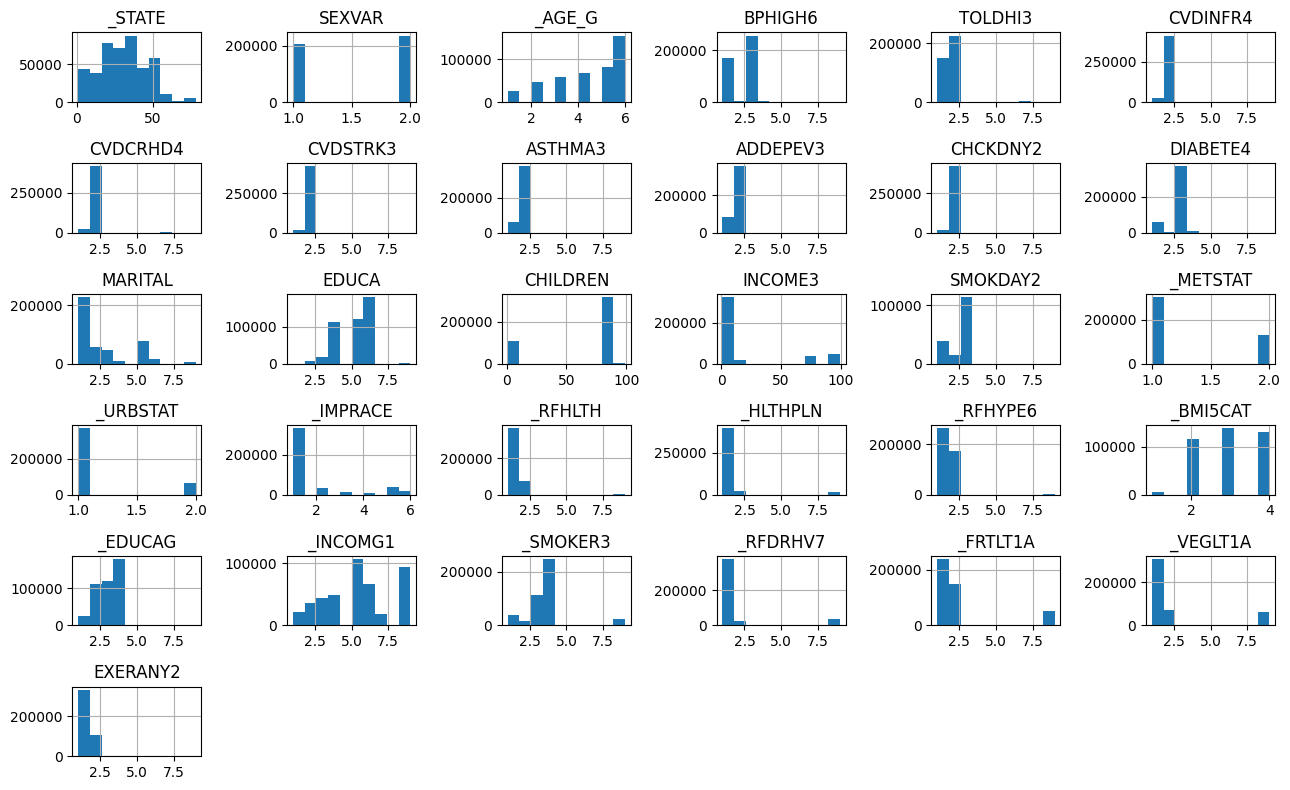

--------- MISSING VALUES ---------
BPHIGH6          2
TOLDHI3      60836
CVDINFR4         2
CVDCRHD4         2
CVDSTRK3         2
ASTHMA3          2
ADDEPEV3         3
CHCKDNY2         3
DIABETE4         3
MARITAL          5
EDUCA            5
CHILDREN      6135
INCOME3       8847
SMOKDAY2    271240
_METSTAT      7054
_URBSTAT      7054
_BMI5CAT     46852
EXERANY2         2
dtype: int64


In [4]:
print("--------- KEYS ---------")
print(work_df.keys())
print("--------- HEAD ---------")
print(work_df.head(n=10))
print("--------- INFO ---------")
print(work_df.info())
print("--------- HISTOGRAMS ---------")
work_df.hist(figsize=(13, 8))
plt.tight_layout()
plt.show()
print("--------- MISSING VALUES ---------")
m = work_df.isnull().sum()
print(m[m > 0])

---
## 4. Data Cleaning & Feature Engineering
To prepare the dataset for machine learning, I took the following steps to clean the data and create features:  
- I converted the column values to binary where possible.  
- I deleted rows with missing values, as well as values where the answer was "Don’t know/Refused/Missing", "Not asked", or similar. 
- I renamed the columns so they are more clearly labeled.  
- I extracted a smaller subset of relevant columns and saved this cleaned data to a new file. 

***Analysis of the Cleaned Data:***  
- There are 330,344 rows and 16 columns.
- There are 0 missing values.  
- All columns are in binary format except age_group, race, and bmi_category.  
- The kidney_disease column is comprised of 317,461 false responses, and 12,883 true responses.

***Format of the Cleaned Data:***  
| Original Column Name | New Column Name               | New Values          |
|:---                  |:---                           |:---                 |
| BPHIGH6              | high_blood_pressure           | true = 1, false = 0 |
| DIABETE4             | diabetes                      | true = 1, false = 0 |
| `_SMOKER3`            | current_or_former_smoker      | true = 1, false = 0 |
| CVDINFR4             | heart_attack                  | true = 1, false = 0 |
| CVDCRHD4             | angina_coronary_heart_disease | true = 1, false = 0 | 
| CVDSTRK3             | stroke                        | true = 1, false = 0 |
| ADDEPEV3             | depressive_disorder           | true = 1, false = 0 |
| EXERANY2             | exercise_daily                | true = 1, false = 0 |
| CHCKDNY2             | kidney_disease                | true = 1, false = 0 |
| `_RFDRHV7`            | heavy_alcohol_drinker         | true = 1, false = 0 |
| `_VEGLT1A`            | vegetable_consumed_daily      | true = 1, false = 0 |
| `_FRTLT1A`            | fruit_consumed_daily          | true = 1, false = 0 |
| SEXVAR               | male                          | male = 1, female = 0 |
| `_IMPRACE`            | race                          | 1 = White, Non-Hispanic; 2 = Black, Non-Hispanic;<br>3 = Asian, Non-Hispanic; 4 = American Indian/Alaskan Native, Non-Hispanic;<br>5 = Hispanic; 6 = Other race, Non-Hispanic | 
| `_AGE_G`              | age_group                     | 1 = Age 18 to 24; 2 = Age 25 to 34; 3 = Age 35 to 44;<br>4 = Age 45 to 54; 5 = Age 55 to 64; 6 = Age 65 or older |
| `_BMI5CAT`            | bmi_category                  | 1 = Underweight; 2 = Normal Weight; 3 = Overweight; 4 = Obese |
  

In [5]:
# high blood pressure     
def flag_bp(v):
    '''convert column to numerical categories'''
    if v == 1 or v == 2: return 1 # yes
    if v == 3 or v == 4: return 0 # no
    if v == 7 or v == 9: return 9 # unknown, refused, missing
work_df['BPHIGH6'] = work_df['BPHIGH6'].fillna(9)
vector_bp = np.vectorize(flag_bp)
work_df['high_blood_pressure'] = vector_bp(work_df['BPHIGH6'])

# diabetes     
def flag_diab(v):
    '''convert column to numerical categories'''
    if v == 1 or v == 2: return 1 # yes
    if v == 3 or v == 4: return 0 # no
    if v == 7 or v == 9: return 9 # unknown, refused, missing
vector_flag_diab = np.vectorize(flag_diab)
work_df['DIABETE4'] = work_df['DIABETE4'].fillna(9)
work_df['diabetes'] = vector_flag_diab(work_df['DIABETE4'])

# smoker     
def flag_sm(v):
    '''convert column to numerical categories'''
    if v == 1 or v == 2 or v == 3: return 1 # yes
    if v == 4: return 0 # no
    if v == 9: return 9 # unknown, refused, missing
vector_sm = np.vectorize(flag_sm)
work_df['_SMOKER3'] = work_df['_SMOKER3'].fillna(9)
work_df['current_or_former_smoker'] = vector_sm(work_df['_SMOKER3'])

# convert columns that have values 1/2/7/9 to 1/2/9
def convert_values_1279(v):
    '''convert column to numerical categories'''
    if v == 1: return 1  # yes
    if v == 2: return 0  # no
    if v == 7 or v == 9: return 9  # unknown, refused, missing

vector_convert_values_1279 = np.vectorize(convert_values_1279)

# heart attack
work_df['CVDINFR4'] = work_df['CVDINFR4'].fillna(9)
work_df['heart_attack'] = vector_convert_values_1279(work_df['CVDINFR4'])

# angina_coronary_heart_disease
work_df['CVDCRHD4'] = work_df['CVDCRHD4'].fillna(9)
work_df['angina_coronary_heart_disease'] = vector_convert_values_1279(work_df['CVDCRHD4'])

# stroke
work_df['CVDSTRK3'] = work_df['CVDSTRK3'].fillna(9)
work_df['stroke'] = vector_convert_values_1279(work_df['CVDSTRK3'])

# depressive_disorder
work_df['ADDEPEV3'] = work_df['ADDEPEV3'].fillna(9)
work_df['depressive_disorder'] = vector_convert_values_1279(work_df['ADDEPEV3'])

# exercise_daily
work_df['EXERANY2'] = work_df['EXERANY2'].fillna(9)
work_df['exercise_daily'] = vector_convert_values_1279(work_df['EXERANY2'])

# kidney_disease
work_df['CHCKDNY2'] = work_df['CHCKDNY2'].fillna(9)
work_df['kidney_disease'] = vector_convert_values_1279(work_df['CHCKDNY2'])

# vegetable_consumed_daily
work_df['_VEGLT1A'] = work_df['_VEGLT1A'].fillna(9)
work_df['vegetable_consumed_daily'] = vector_convert_values_1279(work_df['_VEGLT1A'])

# fruit_consumed_daily
work_df['_FRTLT1A'] = work_df['_FRTLT1A'].fillna(9)
work_df['fruit_consumed_daily'] = vector_convert_values_1279(work_df['_FRTLT1A'])

# male: sex=2=female becomes 0
work_df['male'] = np.where(work_df['SEXVAR'] == 1, 1, 0)

# heavy_alcohol_drinker - 1=no, convert to 0, 2=yes, convert to 1
work_df['_RFDRHV7'] = work_df['_RFDRHV7'].fillna(9)
work_df['heavy_alcohol_drinker'] = np.where(work_df['_RFDRHV7'] == 1, 0,
                               np.where(work_df['_RFDRHV7'] == 2, 1, 9)) 

# rename other columns
work_df.rename(columns = {'_IMPRACE':'race', '_AGE_G':'age_group', 
                          '_BMI5CAT':'bmi_category'}, inplace = True)

In [6]:
# delete rows where value is refused/unknown/missing
work_df = work_df[work_df.kidney_disease != 9]
work_df = work_df[work_df.diabetes != 9]
work_df = work_df[work_df.depressive_disorder != 9]
work_df = work_df[work_df.stroke != 9]
work_df = work_df[work_df.angina_coronary_heart_disease != 9]
work_df = work_df[work_df.heart_attack != 9]
work_df = work_df[work_df.high_blood_pressure != 9]
work_df = work_df[work_df.exercise_daily != 9]
work_df = work_df[work_df.vegetable_consumed_daily != 9]
work_df = work_df[work_df.fruit_consumed_daily != 9]
work_df = work_df[work_df.heavy_alcohol_drinker != 9]
work_df = work_df[work_df.current_or_former_smoker != 9]

# delete rows where bmi is null
work_df = work_df.dropna(axis=0, subset=['bmi_category'])

In [7]:
# create a list of all the new column names
new_col_list = ['kidney_disease', 'age_group', 'male', 'race', 'bmi_category', 
                'current_or_former_smoker', 'heavy_alcohol_drinker', 'fruit_consumed_daily', 
                'vegetable_consumed_daily', 'exercise_daily', 'high_blood_pressure', 'heart_attack', 
                'angina_coronary_heart_disease', 'stroke', 'depressive_disorder', 'diabetes']

# extract the columns into a new df
clean_df = work_df[new_col_list].reset_index(drop = True)

# write the data to an excel file
clean_df.to_csv('3-brfss_2021_subset_cleaned.csv', index = True)

Rows/columns:  (330344, 16)
--------- HISTOGRAMS ---------


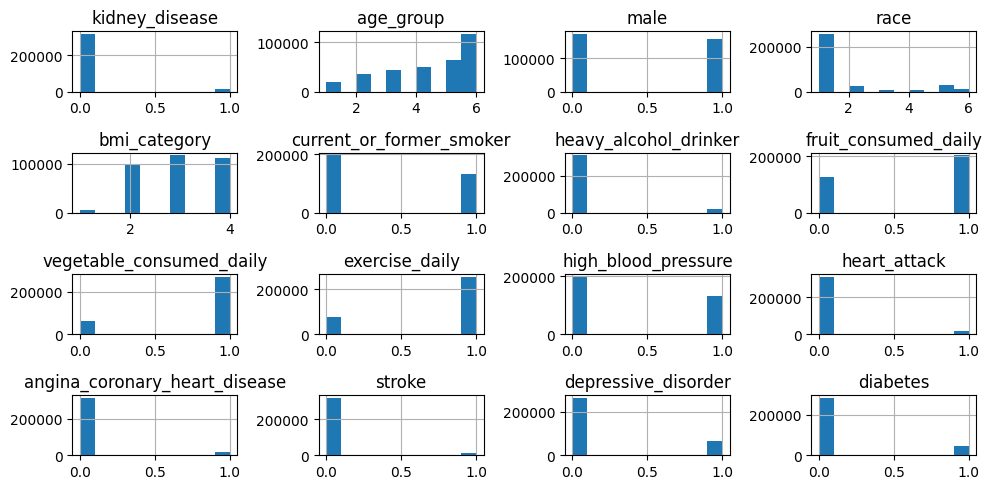

--------- MISSING VALUES ---------
kidney_disease                   0
age_group                        0
male                             0
race                             0
bmi_category                     0
current_or_former_smoker         0
heavy_alcohol_drinker            0
fruit_consumed_daily             0
vegetable_consumed_daily         0
exercise_daily                   0
high_blood_pressure              0
heart_attack                     0
angina_coronary_heart_disease    0
stroke                           0
depressive_disorder              0
diabetes                         0
dtype: int64
--------- KIDNEY DISEASE COUNTS ---------
kidney_disease
0    317461
1     12883
dtype: int64
--------- CORRELATION MATRIX ---------


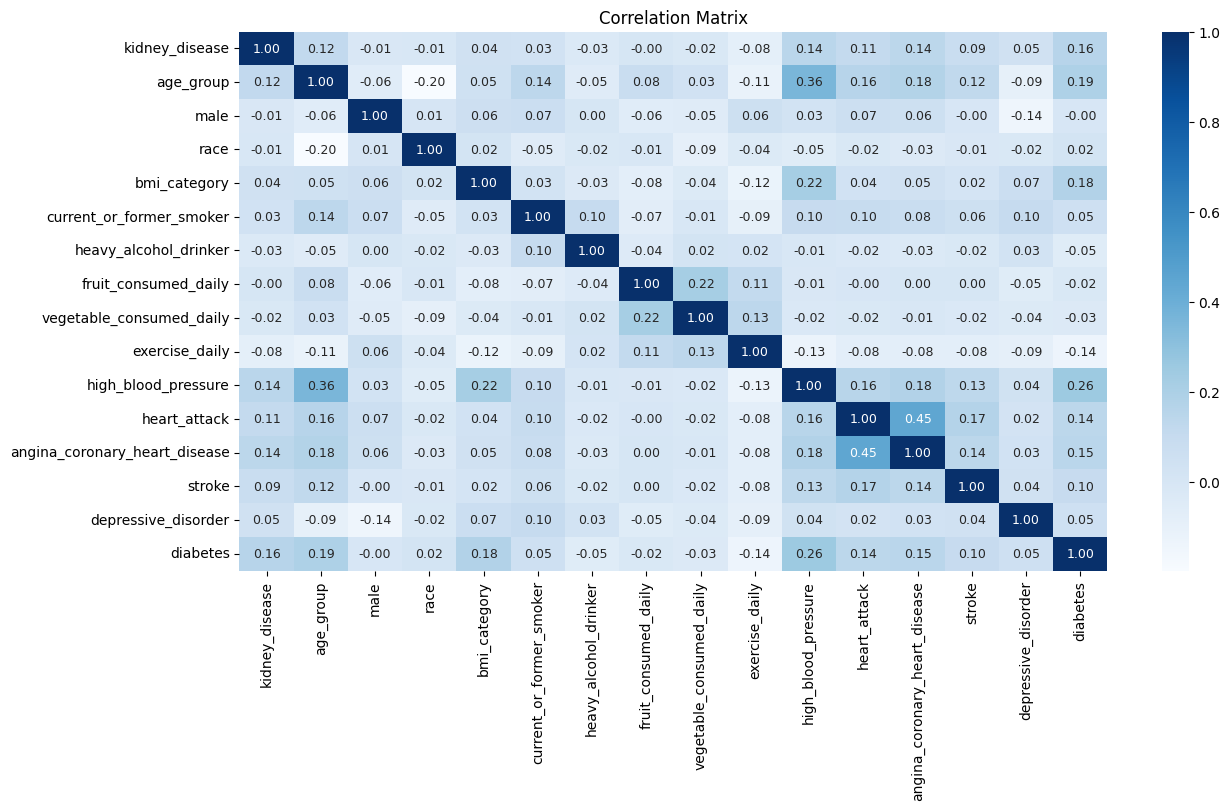

--------- HEATMAP ---------


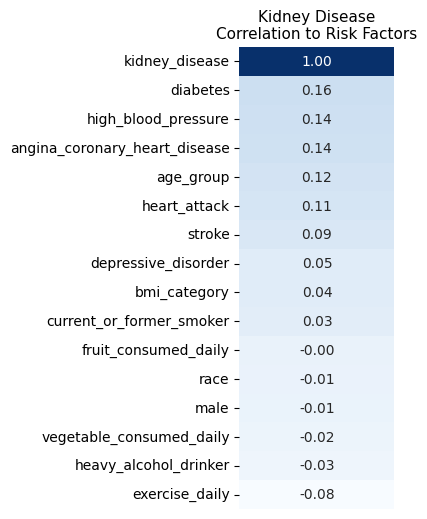

In [8]:
# review clean_df
print("Rows/columns: ", clean_df.shape)
print("--------- HISTOGRAMS ---------")
clean_df.hist(figsize=(10, 5))
plt.tight_layout()
plt.show()
print("--------- MISSING VALUES ---------")
print(clean_df.isnull().sum())
print("--------- KIDNEY DISEASE COUNTS ---------")
print(clean_df.groupby(['kidney_disease']).size())
print("--------- CORRELATION MATRIX ---------")
fig, ax = plt.subplots(figsize=(14,7))
corr = clean_df.corr()
sns.heatmap(corr, annot=True, annot_kws={'size': 9}, fmt='.2f', cmap="Blues")
plt.yticks(rotation=0)
ax.set_title('Correlation Matrix')
plt.show()
print("--------- HEATMAP ---------")
fig, ax = plt.subplots(figsize=(2,6))
corr = clean_df.corr()
x = corr[['kidney_disease']]
sns.heatmap(x.sort_values(by=['kidney_disease'],ascending=False), annot=True, 
            annot_kws={'size': 10}, fmt='.2f', cmap="Blues", cbar=False, xticklabels=False)
plt.yticks(rotation=0)
ax.set_title('Kidney Disease\nCorrelation to Risk Factors', fontsize=11)
plt.show()

---
## 5. Create Training & Test Datasets
- I split the cleaned dataset into a training and test set using a 70/30 split.
    - Train size: 231,240 rows
    - Test size: 99,104 rows
- I set the Target/Dependent Variable as Kidney_Disease.
- I included all other columns as Features/Independent Variables to start.

In [9]:
train_set, test_set = train_test_split(clean_df, test_size=0.3, random_state=123)

print('Train size:', len(train_set))
print('Test size:', len(test_set))

# create features and target variables
X_train = train_set.drop('kidney_disease',axis=1) #features
y_train = train_set['kidney_disease'] #target
X_test = test_set.drop('kidney_disease',axis=1) #features
y_test = test_set['kidney_disease'] #target

print("Train set:")
print(X_train.head(5))

Train size: 231240
Test size: 99104
Train set:
        age_group  male  race  bmi_category  current_or_former_smoker   
118534        4.0     1   1.0           4.0                         0  \
291144        5.0     1   1.0           4.0                         1   
131855        1.0     0   1.0           4.0                         0   
108955        4.0     0   1.0           3.0                         1   
283098        3.0     1   1.0           4.0                         0   

        heavy_alcohol_drinker  fruit_consumed_daily  vegetable_consumed_daily   
118534                      0                     0                         1  \
291144                      0                     0                         1   
131855                      0                     0                         1   
108955                      0                     0                         1   
283098                      0                     0                         0   

        exercise_daily  hig

---
## 6. Determine Features 
- I updated the training and test sets to use the top features shown in the heatmap:  
diabetes, high_blood_pressure, angina_coronary_heart_disease, age_group, heart_attack, stroke

In [10]:
X_train = X_train[['diabetes','high_blood_pressure','angina_coronary_heart_disease','age_group']]#,'heart_attack','stroke']]
X_test =  X_test[['diabetes','high_blood_pressure','angina_coronary_heart_disease','age_group']]#,'heart_attack']]#,'stroke']]

print("Train set:")
print(X_train.head(5))

Train set:
        diabetes  high_blood_pressure  angina_coronary_heart_disease   
118534         0                    0                              0  \
291144         0                    0                              0   
131855         0                    0                              0   
108955         0                    0                              0   
283098         0                    1                              0   

        age_group  
118534        4.0  
291144        5.0  
131855        1.0  
108955        4.0  
283098        3.0  


---
## 7. Resampling the Training Set
- I applied a resampling technique on the training set because the kidney_disease responses are imbalanced.
- I used Synthetic Minority Over-sampling Technique (SMOTE) from imbalanced-learn.

Total class of 1 and 0 before resampling:
 kidney_disease
0    222128
1      9112
Name: count, dtype: int64

Total class of 1 and 0 afer resampling:
 kidney_disease
0    222128
1    222128
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

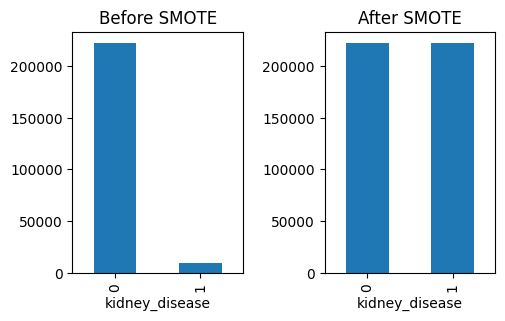

In [11]:
# Synthetic Minority Over-sampling Technique
sm = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Total class of 1 and 0 before resampling:\n", y_train.value_counts())
print()
print("Total class of 1 and 0 afer resampling:\n", y_train_resampled.value_counts())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,3))
plt.tight_layout(w_pad=2.5)
ax1 = y_train.value_counts().plot(kind='bar', title='Before SMOTE', ax=ax1)
ax2 = y_train_resampled.value_counts().plot(kind='bar', title='After SMOTE', ax=ax2)     
plt.show

---
## 8. Train the Models 
- I trained a model with the training set, and then applied the model to the test set to predict kidney diease on unseen data.  
- Then I printed the metrics for the model to review the results. 
- I experimented with a few different models before deciding on Decision Tree and Random Forest.   
- I also experimented with a few different feature combinations.

### <br>8.1. XGB Model


Results for XGB on Train Data

Confusion Matrix:


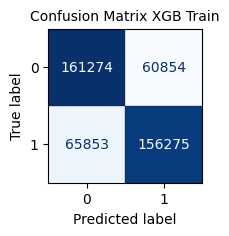


Accuracy is   0.714788320247785
F1 is         0.7147522023911766
Precision is  0.7148971607002029
Recall is     0.714788320247785

Classification Report:
              precision    recall  f1-score   support

           0     0.7101    0.7260    0.7180    222128
           1     0.7197    0.7035    0.7115    222128

    accuracy                         0.7148    444256
   macro avg     0.7149    0.7148    0.7148    444256
weighted avg     0.7149    0.7148    0.7148    444256

-------------------------------

Results for XGB on Test Data

Confusion Matrix:


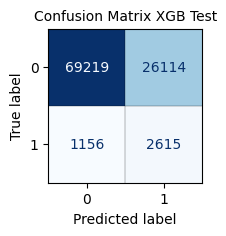


Accuracy is   0.7248345172747821
F1 is         0.809767663099352
Precision is  0.9496113221874334
Recall is     0.7248345172747821

Classification Report:
              precision    recall  f1-score   support

           0     0.9836    0.7261    0.8354     95333
           1     0.0910    0.6935    0.1609      3771

    accuracy                         0.7248     99104
   macro avg     0.5373    0.7098    0.4982     99104
weighted avg     0.9496    0.7248    0.8098     99104

-------------------------------

CPU times: total: 2min 2s
Wall time: 10.9 s


In [12]:
%%time

# train the model
xgb_model = xgb.XGBClassifier(random_state=42, min_child_weight=1000)
xgb_model.fit(X_train_resampled, y_train_resampled)

# display metrics for training data 
y_train_pred = xgb_model.predict(X_train_resampled)
print('\nResults for XGB on Train Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_train_resampled, y_train_pred)
lbl = xgb_model.classes_
plot_cm('Confusion Matrix XGB Train', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_train_resampled, y_train_pred)) 
print('F1 is        ', f1_score(y_train_resampled, y_train_pred, average='weighted')) 
print('Precision is ', precision_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_train_resampled, y_train_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_train_resampled, y_train_pred, zero_division=0, digits=4)) 

print('-------------------------------')

# display metrics for test data 
y_test_pred = xgb_model.predict(X_test)
print('\nResults for XGB on Test Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_test, y_test_pred)
lbl = xgb_model.classes_
plot_cm('Confusion Matrix XGB Test', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_test, y_test_pred)) 
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted')) 
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4)) 

print('-------------------------------\n') 

### <br><br>8.2. Random Forest Model


Results for Random Forest on Train Data

Confusion Matrix:


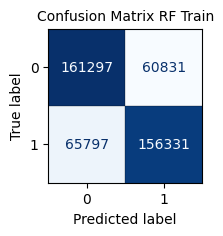


Accuracy is   0.7149661456457538
F1 is         0.714930525348295
Precision is  0.7150736420673239
Recall is     0.7149661456457538

Classification Report:
              precision    recall  f1-score   support

           0     0.7103    0.7261    0.7181    222128
           1     0.7199    0.7038    0.7117    222128

    accuracy                         0.7150    444256
   macro avg     0.7151    0.7150    0.7149    444256
weighted avg     0.7151    0.7150    0.7149    444256

-------------------------------

Results for Random Forest on Test Data

Confusion Matrix:


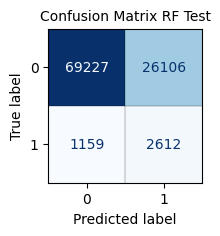


Accuracy is   0.7248849693251533
F1 is         0.8098022404827238
Precision is  0.9495701430122215
Recall is     0.7248849693251533

Classification Report:
              precision    recall  f1-score   support

           0     0.9835    0.7262    0.8355     95333
           1     0.0910    0.6927    0.1608      3771

    accuracy                         0.7249     99104
   macro avg     0.5372    0.7094    0.4981     99104
weighted avg     0.9496    0.7249    0.8098     99104

-------------------------------

CPU times: total: 1min 41s
Wall time: 1min 43s


In [13]:
%%time

# train the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=500)
rf_model.fit(X_train_resampled, y_train_resampled)

# display metrics for training data 
y_train_pred = rf_model.predict(X_train_resampled)
print('\nResults for Random Forest on Train Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_train_resampled, y_train_pred)
lbl = rf_model.classes_
plot_cm('Confusion Matrix RF Train', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_train_resampled, y_train_pred)) 
print('F1 is        ', f1_score(y_train_resampled, y_train_pred, average='weighted')) 
print('Precision is ', precision_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_train_resampled, y_train_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_train_resampled, y_train_pred, zero_division=0, digits=4)) 

print('-------------------------------')

# display metrics for test data 
y_test_pred = rf_model.predict(X_test)
print('\nResults for Random Forest on Test Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_test, y_test_pred)
lbl = rf_model.classes_
plot_cm('Confusion Matrix RF Test', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_test, y_test_pred)) 
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted')) 
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4)) 

print('-------------------------------\n') 

### <br><br>8.3. Linear SGD Model


Results for SGD on Train Data

Confusion Matrix:


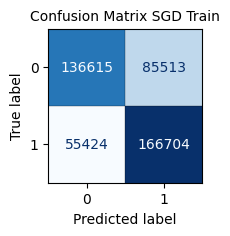


Accuracy is   0.6827572390693654
F1 is         0.6812952726064406
Precision is  0.6861733054846498
Recall is     0.6827572390693654

Classification Report:
              precision    recall  f1-score   support

           0     0.7114    0.6150    0.6597    222128
           1     0.6610    0.7505    0.7029    222128

    accuracy                         0.6828    444256
   macro avg     0.6862    0.6828    0.6813    444256
weighted avg     0.6862    0.6828    0.6813    444256

-------------------------------

Results for SGD on Test Data

Confusion Matrix:


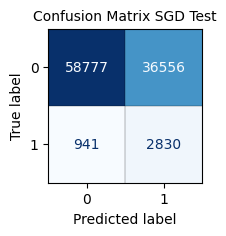


Accuracy is   0.6216398934452696
F1 is         0.7343049586086385
Precision is  0.9495253258418969
Recall is     0.6216398934452696

Classification Report:
              precision    recall  f1-score   support

           0     0.9842    0.6165    0.7582     95333
           1     0.0719    0.7505    0.1311      3771

    accuracy                         0.6216     99104
   macro avg     0.5280    0.6835    0.4447     99104
weighted avg     0.9495    0.6216    0.7343     99104

-------------------------------

CPU times: total: 2.66 s
Wall time: 2.78 s


In [14]:
%%time

# train the model
sgd_model = SGDClassifier(random_state=42, shuffle=True)
sgd_model.fit(X_train_resampled, y_train_resampled)

# display metrics for training data 
y_train_pred = sgd_model.predict(X_train_resampled)
print('\nResults for SGD on Train Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_train_resampled, y_train_pred)
lbl = sgd_model.classes_
plot_cm('Confusion Matrix SGD Train', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_train_resampled, y_train_pred)) 
print('F1 is        ', f1_score(y_train_resampled, y_train_pred, average='weighted')) 
print('Precision is ', precision_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_train_resampled, y_train_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_train_resampled, y_train_pred, zero_division=0, digits=4)) 

print('-------------------------------')

# display metrics for test data 
y_test_pred = sgd_model.predict(X_test)
print('\nResults for SGD on Test Data')

print("\nConfusion Matrix:") 
cm = confusion_matrix(y_test, y_test_pred)
lbl = sgd_model.classes_
plot_cm('Confusion Matrix SGD Test', cm, lbl)

print() 
print('Accuracy is  ', accuracy_score(y_test, y_test_pred)) 
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted')) 
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted', zero_division=0)) 
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted')) 

print("\nClassification Report:") 
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4)) 

print('-------------------------------\n') 

---
## 9. Evaluate the Models' Performance  
- I compiled the metrics for each model below for comparison and evaluation.  

Features:
- Run 1: Diabetes, High Blood Pressure, Angina/Coronary Heart Disease  
- Run 2: Diabetes, High Blood Pressure, Angina/Coronary Heart Disease, Age Group  
- Run 3: Diabetes, High Blood Pressure, Angina/Coronary Heart Disease, Age Group, Heart Attack  
- Run 4: Diabetes, High Blood Pressure, Angina/Coronary Heart Disease, Age Group, Heart Attack, Stroke

|RESULTS:      |    |TRAIN       |      |             |          |    |    |TEST        |      |             |          |
|:---          |:---|:---        |:---  |:---         |:---      |:---|:---|:---        |:---  |:---         |:---      |
|**Model**     |    |**Accuracy**|**F1**|**Precision**|**Recall**|    |    |**Accuracy**|**F1**|**Precision**|**Recall**|
|**Run 1**     |    |            |      |             |          |    |    |            |      |             |          |
|XGBoost       |    | 69.51      |68.99 |70.89        |69.51     |    |    |57.73       |69.84 |95.28        |57.73     | 
|Random Forest |    | 69.51      |68.99 |70.89        |69.51     |    |    |57.73       |69.84 |95.28        |57.73     | 
|Linear SGD    |    | 68.28      |68.13 |68.62        |68.28     |    |    |62.16       |73.43 |94.95        |62.16     |
|**Run 2**     |    |            |      |             |          |    |    |            |      |             |          |
|XGBoost       |    | 71.50      |71.49 |71.51        |71.50     |    |    |72.49       |80.98 |94.96        |72.49     |
|Random Forest |    | 71.50      |71.49 |71.51        |71.50     |    |    |72.49       |80.98 |94.96        |72.49     |
|Linear SGD    |    | 68.28      |68.13 |68.62        |68.28     |    |    |62.16       |73.43 |94.95        |62.16     |
|**Run 3**     |    |            |      |             |          |    |    |            |      |             |          |
|XGBoost       |    | 71.67      |71.67 |71.67        |71.67     |    |    |71.81       |80.51 |95.00        |71.81     |
|Random Forest |    | 71.67      |71.67 |71.67        |71.67     |    |    |71.81       |80.51 |95.00        |71.81     |
|Linear SGD    |    | 68.27      |68.13 |68.61        |68.27     |    |    |62.16       |73.43 |94.95        |62.16     |
|**Run 4**     |    |            |      |             |          |    |    |            |      |             |          |
|XGBoost       |    | 72.04      |72.04 |72.05        |72.04     |    |    |71.01       |79.95 |95.04        |71.01     |
|Random Forest |    | 72.04      |72.04 |72.05        |72.04     |    |    |71.01       |79.95 |95.04        |71.01     |
|Linear SGD    |    | 68.27      |68.12 |68.61        |68.27     |    |    |62.16       |73.43 |94.95        |62.16     |


---
## 10. Model Selection  


- I selected the XGBoost model with the Run 2 feature set because it resulted in the highest F1 score.
- The Run 2 feature sets performed the best of the 4 experiments.
- The XGBoost model outperformed the other the Linear SGD overall. It performed the same as Random Forest, and took less time to run.

In [15]:
# save the model to a file
pickle.dump(xgb_model, open('final_kd_model.pkl', 'wb'))

---
## 11. Run the Model on a New Dataset
- I applied the model to the 2019 BRFSS data, which includes the same columns and data types as the 2021 data.
- I extracted the prediction and the probability score.

### 11.1. Load & Clean a New Dataset  

In [16]:
new_source_file = 'C:\\Users\mandi\data_files\llcp2019.xpt'

# read the file into a dataframe
df_new = pd.read_sas(new_source_file, format='xport', encoding='iso-8859-1')

# add an id field
df_new.insert(loc=0, column='respondent_id', value=np.arange(len(df_new)))
df_new['respondent_id'] = "2019-" + df_new['respondent_id'].astype(str)

# save to file
#df_new.to_csv('output_original_data.csv', index = False)
print("Rows/columns in Original File: ", df_new.shape)
#print(df_new.describe(include='all'))

# --------------------------------#

# create a working set for the model
# keep respondent_id to join the results back to the file
keep_col_new = ['respondent_id', '_AGE_G', 'BPHIGH4', 'CVDINFR4', 'CVDCRHD4', 'CHCKDNY2', 'DIABETE4']

# extract the needed columns into a new working df
work_df_new = df_new[keep_col_new].reset_index(drop = True)
#print(work_df_new)

# --------------------------------#

# data cleaning & feature engineering steps

# high blood pressure     
work_df_new['BPHIGH4'] = work_df_new['BPHIGH4'].fillna(9)
work_df_new['high_blood_pressure'] = vector_bp(work_df_new['BPHIGH4'].astype(int))

# diabetes     
work_df_new['DIABETE4'] = work_df_new['DIABETE4'].fillna(9)
work_df_new['diabetes'] = vector_flag_diab(work_df_new['DIABETE4'].astype(int))

# convert columns that have values 1/2/7/9 to 1/2/9
# heart attack
work_df_new['CVDINFR4'] = work_df_new['CVDINFR4'].fillna(9)
work_df_new['heart_attack'] = vector_convert_values_1279(work_df_new['CVDINFR4'].astype(int))

# angina_coronary_heart_disease
work_df_new['CVDCRHD4'] = work_df_new['CVDCRHD4'].fillna(9)
work_df_new['angina_coronary_heart_disease'] = vector_convert_values_1279(work_df_new['CVDCRHD4'].astype(int))

# kidney_disease
work_df_new['CHCKDNY2'] = work_df_new['CHCKDNY2'].fillna(9)
work_df_new['kidney_disease'] = vector_convert_values_1279(work_df_new['CHCKDNY2'].astype(int))

# rename age group
work_df_new.rename(columns = {'_AGE_G':'age_group'}, inplace = True)
work_df_new['age_group'] = work_df_new['age_group'].astype(int) 

# delete rows where value is refused/unknown/missing
work_df_new = work_df_new[work_df_new.kidney_disease != 9]
work_df_new = work_df_new[work_df_new.diabetes != 9]
work_df_new = work_df_new[work_df_new.angina_coronary_heart_disease != 9]
work_df_new = work_df_new[work_df_new.high_blood_pressure != 9]
work_df_new = work_df_new[work_df_new.heart_attack != 9]

# create a new df for the cleaned data
prod_data = work_df_new[['respondent_id','kidney_disease','diabetes','high_blood_pressure','angina_coronary_heart_disease','age_group','heart_attack']]

Rows/columns in Original File:  (418268, 343)


Rows/columns in Prod File:  (409225, 7)
--------- HISTOGRAMS ---------


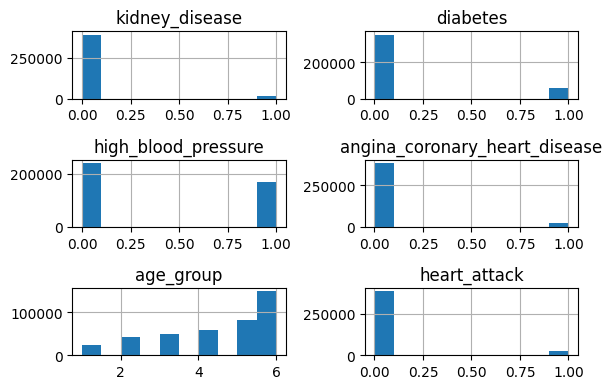

--------- MISSING VALUES ---------
respondent_id                    0
kidney_disease                   0
diabetes                         0
high_blood_pressure              0
angina_coronary_heart_disease    0
age_group                        0
heart_attack                     0
dtype: int64
--------- KIDNEY DISEASE COUNTS ---------
kidney_disease
0    393571
1     15654
dtype: int64


In [17]:
# review clean_df
print("Rows/columns in Prod File: ", prod_data.shape)
print("--------- HISTOGRAMS ---------")
prod_data.hist(figsize=(6, 4))
plt.tight_layout()
plt.show()
print("--------- MISSING VALUES ---------")
print(prod_data.isnull().sum())
print("--------- KIDNEY DISEASE COUNTS ---------")
print(prod_data.groupby(['kidney_disease']).size())

### 11.2. Run the Model on the New Dataset

In [18]:
# set features and target for the model
X_prod = prod_data[['diabetes','high_blood_pressure','angina_coronary_heart_disease','age_group']] 
y_prod = prod_data['kidney_disease'] 

# make predictions  
model = pickle.load(open('final_kd_model.pkl', 'rb'))
y_prod_pred = model.predict(X_prod)
y_proba = model.predict_proba(X_prod)
yp_df = pd.DataFrame(list(y_proba))

# add results to the dataframe
prod_data['kidney_disease_prediction'] = pd.Series(y_prod_pred).values
prod_data['probability_0'] = yp_df[0]
prod_data['probability_1'] = yp_df[1]

print("Predicted true:", prod_data['kidney_disease_prediction'].sum())

Predicted true: 124361


---
## 12. Generate Risk Scores & Levels
- I used the probability of true kidney disease prediction generated by the model as the risk score.
- I stratified the scores into Minimal, Low, Moderate, or High risk groups.
| Risk Stratification |         |
|--- |---|  
| **Risk Level:**     |**Risk Score Ranges**|
| High                | 75-100             |
| Moderate            | 50-74              |
| Low                 | 25-49              | 
| Minimal             | 0-24               | 

In [19]:
# create risk levels
prod_data['risk_level'] = np.where(prod_data['probability_1'] >= 0.75, "High",
                               np.where(prod_data['probability_1'] >= 0.50, "Moderate",         
                               np.where(prod_data['probability_1'] >= 0.25, "Low",         
                               np.where(prod_data['probability_1'] >= 0.00, "Minimal", 0))))

---
## 13. Load Data Into a PostgreSQL Database
- I created a PostgreSQL database and copied the original 2019 BRFSS data and model results into tables.

In [45]:
# read in the password
with open("pw.txt", "r") as f:
    pw = f.read()

#create database engine object using connection string
cnxn_string = ("postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}")
engine = create_engine(cnxn_string.format(database="CAPSTONE", username="postgres", pswd=pw, host="localhost", port=5432))

# create a connection to the database
conn = psycopg2.connect(database = "CAPSTONE", user="postgres", password=pw, host="localhost", port="5432")
cur = conn.cursor()

### 13.1. Load Model Results 

In [46]:
# write the results to a table then collect statistics
start = datetime.now()
prod_data.to_sql('kd_model_results', engine, index=False, if_exists='replace', method=psql_insert_copy)   
conn.commit()
cur.execute("""ANALYZE kd_model_results;""")
print("Data loaded in " + str(datetime.now()-start) )

Data loaded in 0:00:02.874939


### 13.2. Load 2019 BRFSS Data File 

In [22]:
# write the original data file to a table then collect statistics
start = datetime.now()
df_new.to_sql("brfss_2019_data_original", engine, index=False, if_exists='replace', method=psql_insert_copy)   
conn.commit()
cur.execute("""ANALYZE brfss_2019_data_original;""")
print("Data loaded in " + str(datetime.now()-start) )

Data loaded in 0:01:19.849444


In [23]:
# close the connection
conn.close()
cur.close()

In [24]:
# execute a sql query
data = pd.read_sql_query("""select * from kd_model_results limit 2;""", engine)    
display(data)

data = pd.read_sql_query("""select * from brfss_2019_data_original limit 2;""", engine)    
display(data)

,respondent_id,kidney_disease,diabetes,high_blood_pressure,angina_coronary_heart_disease,age_group,heart_attack,kidney_disease_prediction,probability_0,probability_1,risk_level
0,2019-0,0,0,1,0,6,0,1,0.383563,0.616437,Moderate
1,2019-1,0,0,0,0,6,0,0,0.628221,0.371779,Low


,respondent_id,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,...,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3,_AIDTST4
0,2019-0,1.0,1.0,01182019,01,18,2019,1100.0,2019000001,2.019000e+09,...,114.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,2.0,1.0,2.0
1,2019-1,1.0,1.0,01132019,01,13,2019,1100.0,2019000002,2.019000e+09,...,121.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.0,1.0,2.0


---
## 14. Visualizations in Tableau
- I moved over to Tableau to develop visualizations on the SQL data.